In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# using scipy environment to generate samples because it has updated scipy with vonmises_fisher
import numpy as np
from scipy.stats import vonmises_fisher

ImportError: cannot import name 'vonmises_fisher' from 'scipy.stats' (/home/brysongray/anaconda3/envs/fibermetric/lib/python3.9/site-packages/scipy/stats/__init__.py)

## Generate synthetic bimodal distribution on a sphere

In [1]:
angle_pairs = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/angle_pairs.npy')
rng = np.random.default_rng()

samples = np.empty((100, 150, 3), dtype=np.float64)
centers = np.empty((100, 2, 3), dtype=np.float64)
random_uniform = np.random.uniform(low=-1.0, high=1.0, size=(50,3))
random_uniform = random_uniform / np.linalg.norm(random_uniform, axis=1)[:,None]
for i,p in enumerate(angle_pairs):
    u = np.array([np.cos(p[0,0]),np.sin(p[0,0])*np.cos(p[0,1]),np.sin(p[0,0])*np.sin(p[0,1])])
    v = np.array([np.cos(p[1,0]),np.sin(p[1,0])*np.cos(p[1,1]),np.sin(p[1,0])*np.sin(p[1,1])])
    sample1 = vonmises_fisher(u, 20).rvs(50, random_state=rng)
    sample2 = vonmises_fisher(v, 20).rvs(50, random_state=rng)
    sample = np.concatenate((sample1,sample2,random_uniform),axis=0)
    centers[i] = np.array([u,v])
    samples[i] = sample

# np.savez('/home/brysongray/fibermetric/outputs/sta_validate_outputs/apsym_kmeans_test_data.npz',samples=samples, centers=centers)

NameError: name 'np' is not defined

In [2]:
# switch to fibermetric environment
%matplotlib widget
import os
import sys
import matplotlib.pyplot as plt
from time import time
from dipy.core.sphere import disperse_charges, HemiSphere
import torch
from torch.nn import Upsample
import scipy


import numpy as np

sys.path.append('../fibermetric/')
import sta_validate
import histology
import apsym_kmeans
import diffusion
import utils


data = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/apsym_kmeans_test_data.npz')
samples = data['samples']
centers = data['centers']

## Test k-means on synthetic bimodal distribution

In [3]:
rng = np.random.default_rng()
skm = apsym_kmeans.APSymKMeans(n_clusters=2, verbose=False, random_state=0, n_init=1)
diff = []
for i in range(len(samples)):
    skm.fit(samples[i])
    mu = skm.cluster_centers_
    diff_ = np.empty((len(mu),len(centers[i]))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(mu)):
        for n in range(len(centers[i])):
            diff_[m,n] = np.arccos(np.abs(mu[m].dot(centers[i,n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff.append(np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi)


In [4]:
print(f'mean of difference (degrees): {np.mean(diff)}')
print(f'standard deviation (degrees): {np.std(diff)}')

mean of difference (degrees): 13.630523944921558
standard deviation (degrees): 14.12965318329557


## look at distribution of errors for two angle phantoms

In [20]:
# in 3D
n = (12, 72, 72)
d = (6.0, 1.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
# phantom_angles = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/angles.npy')
angle_pairs = np.load('/home/brysongray/fibermetric/outputs/sta_validate_outputs/angle_pairs.npy')

# phantom_angle = np.array([[2.33803817, 0.77978514],
#                           [1.39072774, 2.96977006]])
phantoms = []
phantoms_= []
for phantom_angle in angle_pairs:
    phantoms.append(sta_validate.make_phantom(x, phantom_angle, period=10.0, noise=1e-12))
    phantoms_.append(sta_validate.make_phantom(x, phantom_angle, period=10.0, noise=1e-12, blur_correction=True))

# plt.figure()
# plt.imshow(img[:,:,36])

In [29]:
skm = apsym_kmeans.APSymKMeans(n_clusters=2, n_init=1, random_state=0)


median of difference (degrees): 26.234129568664592
median absolute deviation (degrees): 16.20735984975631
mean of difference (degrees): 27.581093317079628
standard deviation (degrees): 17.705964904865624
max: 70.15663869088647
time: 97.80413126945496 seconds


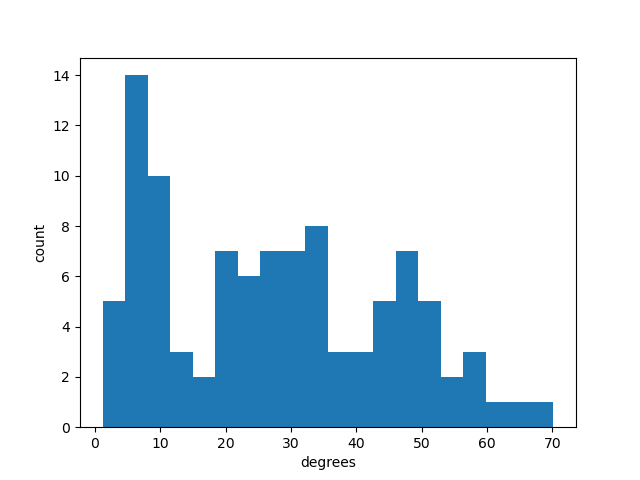

In [27]:
# fit k-means to the angles
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=5.0, num=10)
d = derivative_sigmas[4]
t = tensor_sigmas[2]

start = time()
diffs = []

for i,p in enumerate(phantoms):
    # first blur correct the phantom
    S = histology.structure_tensor(p, derivative_sigma=d, tensor_sigma=t, masked=False, normalize=False)
    angles = histology.angles(S, cartesian=True) # shape (72,72,72,3)
    crop = 12
    angles = angles[crop:-crop, crop:-crop, crop:-crop]

    angles_ = angles.reshape(-1,3)

    # skm = apsym_kmeans.APSymKMeans(n_clusters=2, n_init=1, random_state=0)
    skm.fit(angles_)
    mu = skm.cluster_centers_

    phantom_angle = angle_pairs[i]
    true_thetas = np.array([np.sin(phantom_angle[:,0])*np.sin(phantom_angle[:,1]),
                                    np.sin(phantom_angle[:,0])*np.cos(phantom_angle[:,1]),
                                    np.cos(phantom_angle[:,0])
                                    ]).T

    diff_ = np.empty((len(mu),len(true_thetas))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(mu)):
        for n in range(len(true_thetas)):
            diff_[m,n] = np.arccos(np.abs(mu[m].dot(true_thetas[n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff = np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi
    diffs.append(diff)
end = time()

plt.figure()
plt.hist(diffs, bins=20)
plt.xlabel('degrees')
plt.ylabel('count')

print(f'median of difference (degrees): {np.median(diffs)}')
print(f'median absolute deviation (degrees): {np.median(np.abs(diffs - np.median(diffs)))}')
print(f'mean of difference (degrees): {np.mean(diffs)}')
print(f'standard deviation (degrees): {np.std(diffs)}')
print(f'max: {np.max(diffs)}')
print(f'time: {end-start} seconds')

median of difference (degrees): 44.569363961200494
median absolute deviation (degrees): 7.887164111147314
mean of difference (degrees): 45.5255656410698
standard deviation (degrees): 13.37150770789967
max: 80.8880209841484
time: 90.36835145950317 seconds


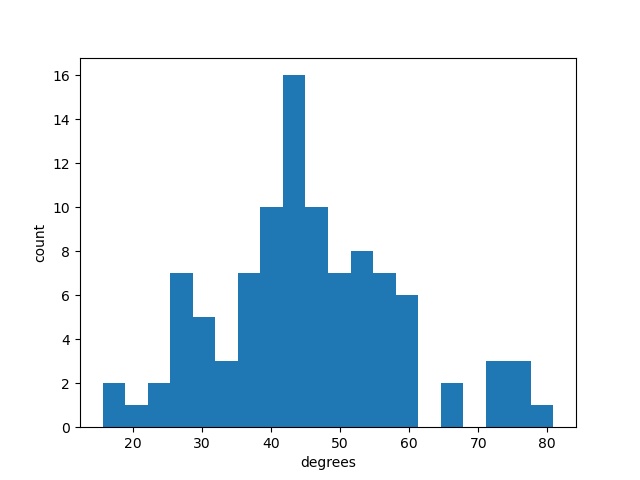

In [30]:
# fit k-means to the angles
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=5.0, num=10)
d = derivative_sigmas[4]
t = tensor_sigmas[2]

start = time()
diffs = []

for i,p in enumerate(phantoms_):
    S = histology.structure_tensor(p, derivative_sigma=d, tensor_sigma=t, masked=False, normalize=False)
    angles = histology.angles(S, cartesian=True) # shape (72,72,72,3)
    crop = 12
    angles = angles[crop:-crop, crop:-crop, crop:-crop]

    angles_ = angles.reshape(-1,3)

    # skm = apsym_kmeans.APSymKMeans(n_clusters=2, n_init=1, random_state=0)
    skm.fit(angles_)
    mu = skm.cluster_centers_

    phantom_angle = angle_pairs[i]
    true_thetas = np.array([np.sin(phantom_angle[:,0])*np.sin(phantom_angle[:,1]),
                                    np.sin(phantom_angle[:,0])*np.cos(phantom_angle[:,1]),
                                    np.cos(phantom_angle[:,0])
                                    ]).T

    diff_ = np.empty((len(mu),len(true_thetas))) # shape (2,2) for two permutations of the difference between two means and two true_thetas
    for m in range(len(mu)):
        for n in range(len(true_thetas)):
            diff_[m,n] = np.arccos(np.abs(mu[m].dot(true_thetas[n])))
    argmax = np.unravel_index(np.argmin(diff_), (2,2))
    corrolary = tuple([1 - x for x in argmax]) # the corresponding cos_dif of the other mu to the other grid_theta
    diff = np.mean([diff_[argmax], diff_[corrolary]]) * 180/np.pi
    diffs.append(diff)
end = time()

plt.figure()
plt.hist(diffs, bins=20)
plt.xlabel('degrees')
plt.ylabel('count')

print(f'median of difference (degrees): {np.median(diffs)}')
print(f'median absolute deviation (degrees): {np.median(np.abs(diffs - np.median(diffs)))}')
print(f'mean of difference (degrees): {np.mean(diffs)}')
print(f'standard deviation (degrees): {np.std(diffs)}')
print(f'max: {np.max(diffs)}')
print(f'time: {end-start} seconds')

## Visualize distribution of angles on a sphere

In [ ]:
# plot a histogram for each component of angles
plt.figure()
for i in range(2):
    plt.hist(angles[:,:,:,i].flatten(), bins=100, alpha=0.5, label=f'component {i}')
# plot the components of phantom_angle as vertical lines
plt.axvline(phantom_angle[0,0], color='r', linestyle='-', label=f'angle {0} component {0}')
plt.axvline(phantom_angle[0,1], color='firebrick', linestyle='-', label=f'angle {0} component {1}')
plt.axvline(phantom_angle[1,0], color='b', linestyle='--', label=f'angle {1} component {0}')
plt.axvline(phantom_angle[1,1], color='c', linestyle='--', label=f'angle {1} component {1}')

# plot the components of mu as vertical lines
plt.axvline(mu[0,0], color='y', linestyle=':', label=f'mu {0} component {0}')
plt.axvline(mu[0,1], color='gold', linestyle=':', label=f'mu {0} component {1}')
plt.axvline(mu[1,0], color='fuchsia', linestyle='-.', label=f'mu {1} component {0}')
plt.axvline(mu[1,1], color='deeppink', linestyle='-.', label=f'mu {1} component {1}')
plt.legend()


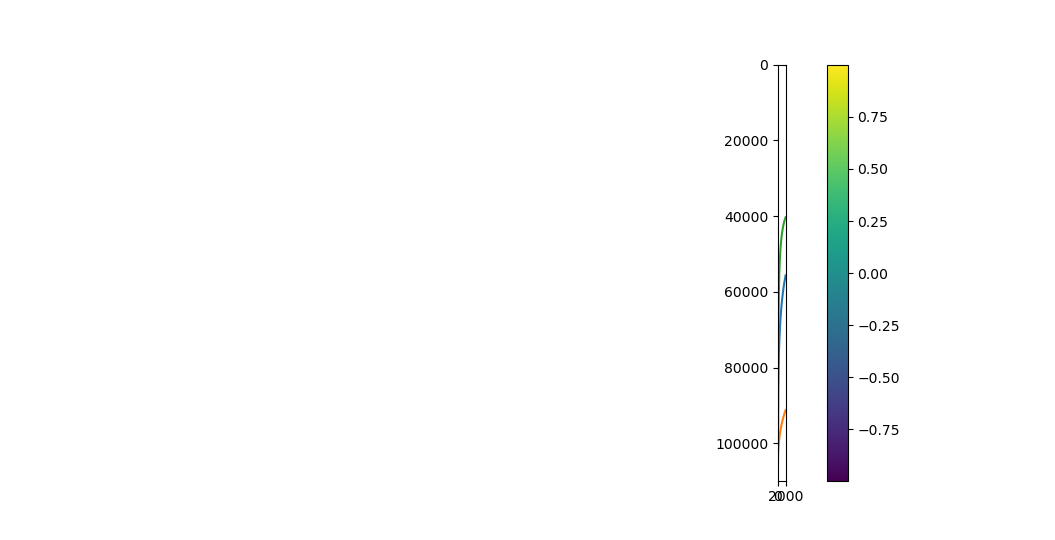

In [10]:
# create points on the sphere
n_pts = 100
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
v_initial = HemiSphere(theta=theta, phi=phi)
v_updated, potential = disperse_charges(v_initial, 2000, const=0.1)
vertices = v_updated.vertices
plt.plot(potential)
plt.show()
# angles = np.array([np.arccos(vertices[:,0]), np.arctan2(vertices[:,2],vertices[:,1])]).T

In [11]:
vertices.shape

(100, 3)

In [14]:
PHI, THETA = np.meshgrid(np.linspace(0, 2*np.pi, 20), np.linspace(0, np.pi, 10))
x = np.sin(THETA) * np.sin(PHI)
y = np.sin(THETA) * np.cos(PHI)
z = np.cos(THETA)
grid = np.stack((x, y, z), axis=0)



# find the distance of each angle to each grid point accounting for antipodal symmetry
angles_ = angles.reshape(-1,3)
grid_ = grid.reshape(3,-1)
dist = angles_ @ grid_
dist = np.arccos(dist)
labels = np.argmax(dist, axis=1)
indices, counts = np.unique(labels, return_counts=True) # indices are the bin indices, counts are the number of angles in each bin

# there are 800 bins, so there should be 800 indices unless there are bins with no angles in them.
# add 0 counts to bins with no angles in them
if len(indices) < dist.shape[1]:
    counts_ = np.zeros(dist.shape[1], dtype=np.int64)
    counts_[indices] = counts
    counts = counts_
# reshape counts to match grid shape
counts = counts.reshape(x.shape)


In [ ]:
grid[:,9,19]

In [16]:
print(grid.shape)
print(dist.shape)
print(labels.shape)
print(indices.shape)
print(counts.shape)

(3, 10, 20)
(110592, 200)
(110592,)
(156,)
(10, 20)


In [ ]:
counts

In [17]:
# fit k-means to the angles
skm = apsym_kmeans.APSymKMeans(n_clusters=1)
skm.fit(angles_)
mu = skm.cluster_centers_[0]
print(mu)


[ 0.05239102 -0.41209986  0.90963118]


NameError: name 'phantom_angle' is not defined

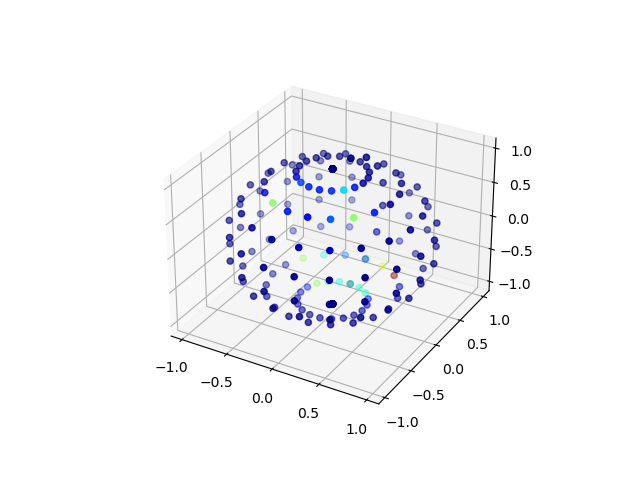

In [18]:
# plot the histogram
# weights = np.sin(THETA)
R = counts / np.max(counts)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.plot_surface(R*x, R*y, R*z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'), linewidth=0, antialiased=False, alpha=0.5)
# ax.plot_surface(R*x, R*y, R*z, cmap=plt.get_cmap('jet'), linewidth=0, antialiased=False, alpha=0.5)
ax.scatter3D(x, y, z, c=R, cmap=plt.get_cmap('jet'))

t = np.linspace(-1.5, 1.5, 100)
theta = phantom_angle[0]
phi = phantom_angle[1]
i = np.sin(theta) * np.sin(phi)
j = np.sin(theta) * np.cos(phi)
k = np.cos(theta)
print(i,j,k)
ax.plot(t*i, t*j, t*k, color='k', linewidth=1)
ax.plot(t*mu[0], t*mu[1], t*mu[2], color='r', linewidth=1)





In [ ]:
R = np.ones((30,20))
R[0,0] = 2.0
R[15,10] = 2.0


ValueError: operands could not be broadcast together with shapes (10,20) (30,20) 

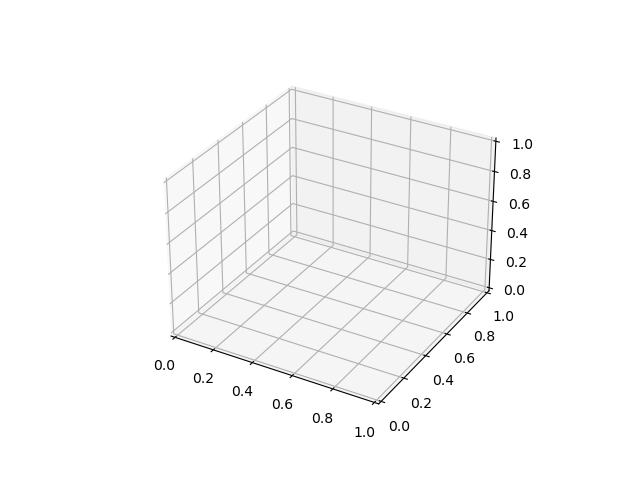

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(R*x, R*y, R*z, cmap=plt.cm.YlGnBu_r)
plt.show()